In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

## Loading Data

In [9]:
test_ratings = pd.read_csv('~/Datasets/food/interactions_test.csv')
train_ratings = pd.read_csv('~/Datasets/food/interactions_train.csv')

In [10]:
ratings = pd.concat([test_ratings, train_ratings])

In [11]:
recipes = pd.read_csv('~/Datasets/food/RAW_recipes.csv')

In [12]:
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


## Exploration

In [13]:
ratings['date'] = pd.to_datetime(ratings['date'], infer_datetime_format=False)
ratings['year'] = ratings['date'].map(lambda x: x.year)

Text(0.5, 1.0, 'Number of submissions per rating')

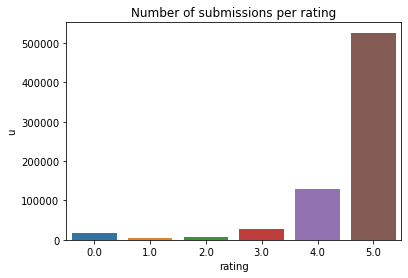

In [14]:
rating_count = ratings.groupby('rating').count()
sns.barplot(x=rating_count.index,y="u",data=rating_count)
plt.title('Number of submissions per rating')

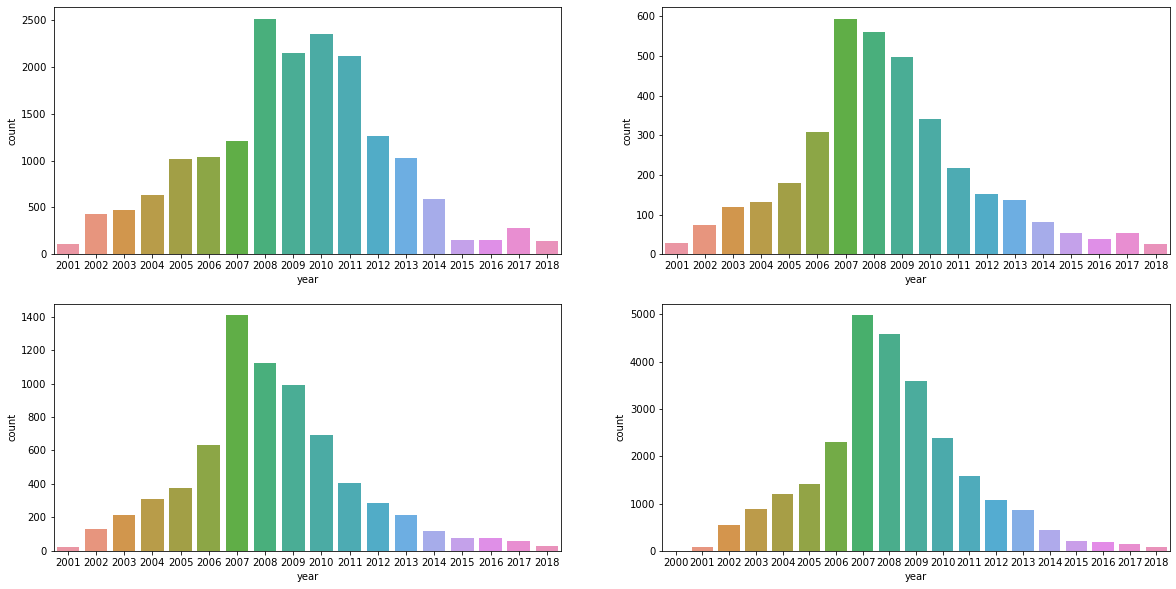

In [16]:
fig, ax = plt.subplots(2,2,figsize=(20,10))
horizontal_axis_counter = 0
rating_groups = [0.0,1.0,2.0,3.0]
num = 0
for i in range(2):
    for j in range(2):
        data = ratings[ratings['rating']==rating_groups[num]]
        sns.countplot(data=data, x='year',ax=ax[i][j])
        num+=1

## Matrix Factorization
### Computing user and recipe embeddings

In [17]:
def recompute_recipe_ids(ratings_df: pd.DataFrame) -> pd.DataFrame:
    recipe_ids = np.sort(ratings_df['i'].unique())
    incrementing_nums = np.array(list(range(0,len(recipe_ids))))
    recipe_ids_map = {recipe_id: incrementing_nums[idx] for idx, recipe_id in enumerate(recipe_ids)}
    ratings_df['recipe_id'] = ratings_df['i'].map(recipe_ids_map)
    return ratings_df

In [18]:
def build_ratings_matrix(ratings_df: pd.DataFrame) -> torch.sparse.FloatTensor:
    num_users = np.amax(ratings_df['u'])+1
    num_recipes = np.amax(ratings_df['recipe_id'])+1
    matrix_size = torch.Size([num_users, num_recipes])
    
    indeces = ratings_df[['u', 'recipe_id']].values
    ratings = ratings_df['rating'].values
    indeces_tensor = torch.LongTensor(indeces)
    ratings_tensor = torch.FloatTensor(ratings)

    ratings_matrix = torch.sparse.FloatTensor(indeces_tensor.t(), ratings_tensor, matrix_size).to_dense()
    return ratings_matrix

In [19]:
train_ratings = recompute_recipe_ids(train_ratings)
ratings_matrix = build_ratings_matrix(train_ratings)

In [22]:
ratings_matrix

tensor([[4., 0., 0.,  ..., 0., 0., 0.],
        [5., 0., 0.,  ..., 0., 0., 0.],
        [0., 4., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self):
        super(MatrixFactorization,self).__init__(num_users, num_recipes, embedding_dim)
        self.user_embedding = torch.nn.Embedding(num_users, embedding_dim, sparse=True)
        self.recipe_embedding = torch.nn.Embedding(num_recipes, embedding_dim, sparse=True)
        
    def forward(user_id, recipe_id):
        #TODO use torch.dot
        return (self.user_embedding(user_id)*self.recipe_embedding(recipe_id)).sum(1)

In [ ]:
def train_model(model, num_epochs:int, train_ratings: torch.sparse.FloatTensor, user_ids: list, ratings_ids: list):
    criterion = torch.nn.MSELoss()
    optimzer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    for user_id, recipe_id in zip(user_ids,recipe_ids):
        optimzer.zero_grad()
        user_rating_prediction = model(user_id, recipe_id)
        actual_rating = train_ratings[user_id][recipe_id]
        loss = criterion(user_rating_prediction, actual_rating)
        loss.backward()
        optimizer.step()
        